# Quick Code Analysis

To get going with this notebook I suggest using VS Code with Python extension.

Create a virtual environment in this folder:

```
python -m venv .venv
```

Select the Python Interpreter from the venv in the quick command menu (Ctrl/Cmd + Shift + P) -> `> Python: Select Interpreter` (refresh the interpreter list or reload the window if it does not show up).

Open a terminal, load the venv if that's not done automatically, and install pandas:

```
pip install pandas
```

Ensure `git` can be be found.

Change the variables below to point to your repo of interest, and give this notebook a spin (VS Code may ask if it needs to install a Jupyter kernel).

In [57]:
path = "../pygobject"
after = "1 year ago"
top = 10

# Regex patterns to exclude from analisys. E.g. generated files.
excludes = [".*\\.svg$", ".*\\.xcf$", ".*\\.png$", ".*\\.gif$", ".*\\.md$", ".*\\.rst$", ".*\\.po$", ".*\\.gaphor$", "poetry.lock", "NEWS.*"]


In [58]:
import os
import re
import pandas
import functools
import itertools
import subprocess
from IPython.core.display import HTML

compiled_excludes = [re.compile(ex) for ex in excludes]


def is_excluded(filename):
    return any(re.search(ex, filename) for ex in compiled_excludes)


lines = []
found_commits = 0
with subprocess.Popen(["git", "log", "--format=format:::: %H,%ci,%an", "--numstat", "--no-renames", f"--after={after}"], cwd=path, stdout=subprocess.PIPE, text=True) as git_log:
    for line in git_log.stdout.readlines():
        line = line.strip()
        if not line:
            continue
        elif line.startswith("::: "):
            meta = line[4:].split(",")
            found_commits += 1
        else:
            try:
                added, removed, filename = line.split("\t", 2)
            except ValueError as e:
                print(f"Error on '{line}': {e}")
                continue
            if not is_excluded(filename):
                rec = [*meta, added, removed, filename]
                assert len(rec) == 6, rec
                lines.append(rec)

df = pandas.DataFrame(lines, columns=["commit", "date", "author", "added", "removed", "filename"])
df['dirname'] = df.apply(lambda row: os.path.dirname(row["filename"]), axis=1)
df['dirname2'] = df.apply(lambda row: os.path.dirname(row["dirname"]), axis=1)

del lines
# df[:top]
(found_commits, len(df))

(58, 115)

# Complexity

We use the simplest complexity metric of all: file size. This metric is language agnostic and tends to be a pretty good indicator for complexity.

In [59]:
from pathlib import Path

cwdpath = Path(path)

with subprocess.Popen(["git", "ls-files"], cwd=path, stdout=subprocess.PIPE, text=True) as git_ls_files:
    complexity = pandas.DataFrame(((line.strip(), os.stat(cwdpath / line.strip()).st_size) for line in git_ls_files.stdout.readlines() if not is_excluded(line.strip())), columns=["filename", "size"]).sort_values("size", ascending=False)

complexity[:top]

,filename,size
225,tests/test_gi.py,126387
244,tests/test_overrides_gtk.py,111762
132,gi/pygi-info.c,79292
86,gi/gimodule.c,75887
166,gi/pygobject-object.c,75601
97,gi/overrides/Gtk.py,62762
221,tests/test_everything.py,56449
251,tests/test_signal.py,55180
246,tests/test_properties.py,52844
108,gi/pygi-argument.c,44840


# Churn

Churn is simply how many times a file has changed in the history of a project. The more often it changed, the higher the "churn".

In [60]:
churn = df.groupby(['filename']).size().reset_index(name='commits').sort_values("commits", ascending=False)
churn[:top]

,filename,commits
20,gi/overrides/Gtk.py,14
56,tests/test_overrides_gtk.py,10
39,meson.build,6
40,pyproject.toml,5
46,tests/__init__.py,4
52,tests/test_gtk_template.py,4
41,setup.py,4
31,gi/pygi-struct-marshal.c,3
1,.gitlab-ci.yml,3
48,tests/test_gi.py,3


# Churn vs Complexity

This is a list of the most complicated files.

,filename,commits,size,churn_complexity
1,tests/test_overrides_gtk.py,10,111762,1117620
0,gi/overrides/Gtk.py,14,62762,878668
9,tests/test_gi.py,3,126387,379161
6,setup.py,4,41510,166040
12,gi/pygi-info.c,2,79292,158584
11,gi/gimodule.c,2,75887,151774
5,tests/test_gtk_template.py,4,19208,76832
21,gi/pygobject-object.c,1,75601,75601
7,gi/pygi-struct-marshal.c,3,23763,71289
13,gi/pygi-closure.c,2,34795,69590


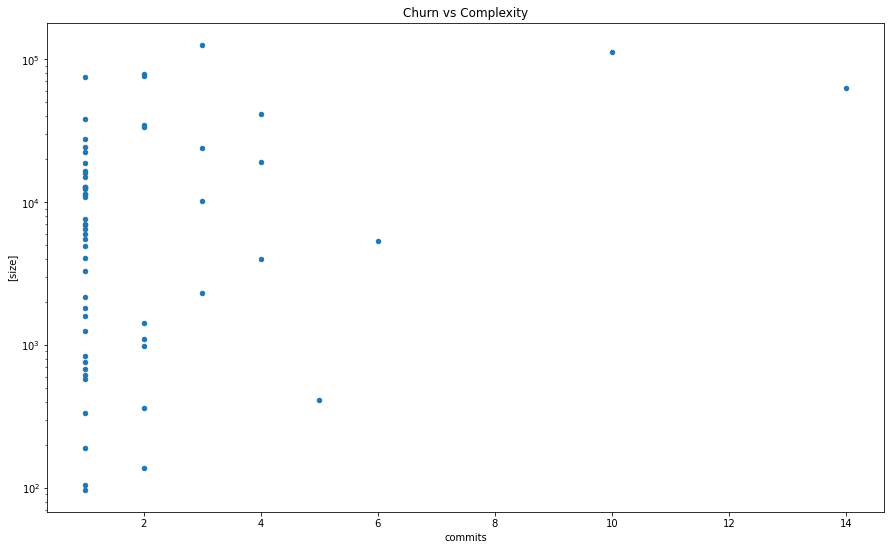

In [61]:
churn_complexity = pandas.merge(churn, complexity, on="filename", suffixes=("_ch", "_co"))
churn_complexity["churn_complexity"] = churn_complexity.apply(lambda row: row["commits"] * row["size"], axis=1)

churn_complexity.plot.scatter(x="commits", y=["size"], title="Churn vs Complexity", figsize=(15,9), logy=True, logx=False)

churn_complexity.sort_values("churn_complexity", ascending=False)[:top]

# Top authors

The authors that contributed most to the repository.

In [62]:
top_authors = df.groupby(['author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors[:top]

,author,commits
1,Christoph Reiter,67
4,Jean Felder,17
7,Tomas Hrnciar,14
3,Emmanuele Bassi,5
6,Philip Withnall,5
0,Arjan Molenaar,3
2,David King,3
5,Miro Hrončok,1


In [63]:
top_authors_per_package = df.groupby(['dirname', 'author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors_per_package[:top]

,dirname,author,commits
15,tests,Christoph Reiter,22
0,,Christoph Reiter,21
10,gi,Tomas Hrnciar,14
2,.gitlab-ci,Christoph Reiter,12
11,gi/overrides,Christoph Reiter,9
17,tests,Jean Felder,7
13,gi/overrides,Jean Felder,5
14,subprojects,Philip Withnall,5
8,gi,Jean Felder,4
12,gi/overrides,Emmanuele Bassi,4


# Change Coupling

Change coupling tells us which files have a tendency to change together.

In [64]:
group_size = 2

def size(iterable):
    return functools.reduce(lambda n, _: n + 1, iterable, 0)

commits = {name: len(commits) for name, commits in df.groupby(["filename"])}

all_file_pairs = sorted(pair for _, group in df.groupby(['commit']) for pair in itertools.combinations(group['filename'], group_size))

combos = {pair: size(pairs) for pair, pairs in itertools.groupby(all_file_pairs)}

change_coupling = sorted(((n / (n + commits[a] + commits[b]), n, a, b) for (a, b), n in combos.items()), reverse=1)[:top*5]

rows = (
    f"""
    <tr><td>{n}</td><td>{file_a}</td><td>{commits[file_a]}</td><td>{int(n / commits[file_a] * 100)}</td></tr>
    <tr><td></td><td>{file_b}</td><td>{commits[file_b]}</td><td>{int(n / commits[file_b] * 100)}</td></tr>
    """ for _, n, file_a, file_b in change_coupling)

HTML(f"<table><th><td>Coupled Entities</td><td>Commits</td><td>% coupling</td></th>{''.join(rows)}</table>")

3,gi/_gtktemplate.py,3,100
,gi/pygi-struct-marshal.c,3,100
2,.gitlab-ci/Dockerfile,2,100
,.gitlab-ci/run-docker.sh,2,100
1,tests/test_overrides_gdk.py,1,100
,tests/test_overrides_glib.py,1,100
1,tests/test_gio.py,1,100
,tests/test_overrides_glib.py,1,100
1,tests/test_gio.py,1,100
,tests/test_overrides_gdk.py,1,100
1,subprojects/libffi.wrap,1,100
